# Don't Give Up on DCT's!!

Everyone in the competition so far, and certainlly all of the public kernels at this point, have all but given up on DCT and focus solely upon spatial-feature model construction. There are some desparate mentions of people attempting to work directly with DCT components, but nothing substantial has really been fleshed out.

**I feel there Must be something in the DCT components.**

The purpose of this notebook is to hopefully get some like minded folk to rally in this direction before the 7-day cooldown deadline and the forums go silent! To prcoeed, please start by reading [this excellent article](https://en.wikipedia.org/wiki/JPEG#Discrete_cosine_transform).

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Uber Research

A few days ago, I came across this absolute gem of a resource: [Faster Neural Networks Straight from JPEG](https://eng.uber.com/neural-networks-jpeg/), by Uber Engineering (Research).

In the work, the authors decided that they wanted to work in DCT space, rather than decoding to YCbCr -> RGB, the idea being, this would speed up some of the computation. Furthermore, they could then get rid of the frist few layers of the traditional neural model and instead try using the DCT Basis weights directly, which are 64 x 8 x 8 kernels (channels first).

![JPEG2DCT](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/12/Header.png)

Through thorough testing, they're able to build out models and pipelines that are faster and actually have lower top-5 error than the alternative, baseline SoTA models at the time:

![Top5 Error](https://1fykyq3mdn5r21tpna3wkdyi-wpengine.netdna-ssl.com/wp-content/uploads/2018/12/image9-1-1920x1329.png)

Uber graciously made the [source code](https://github.com/uber-research/jpeg2dct) available. Their library, JPEG2DCT, is a wrapper for libjpeg, where they exit early in the decoding process. The first thing I was hoping was that this library would be a LOT faster at loading JPEG data. I had tested many different ways of loading data, and the jpeg decoding process is without a doubt the largest bottleneck in my code base (maybe tied with the actual model training).

Getting it working is a bit tricky because by default you'll get a:

`Wrong JPEG library version: library is 90, caller expects 80`

This happens because the Ubuntu Docker image (and Ubuntu itself, even 20.x) has `/usr/lib/x86_64-linux-gnu/libjpeg.so(.8x)` installed on the system, but conda comes with 9x in it's own `~/anaconda3/lib/` path, so stuff gets jacked. To get around it, either get both versions on 8 or get both versions on 9.

On my server, I opted to get both version onto 9, but the trick didn't work on Kaggle kernels, so here we're going to get both versions onto 8. Delete all `libjpeg*` files from the conda lib, and place a copy of the system 8x files there.

In [ ]:
!rm /opt/conda/lib/libjpeg*
!cp /usr/lib/x86_64-linux-gnu/libjpeg* /opt/conda/lib/

!git clone https://github.com/uber-research/jpeg2dct

# Data Engineering PRO TIP!
# Always use `pip install .` rather than `python setup.py install`
# This way, you can later uninstall with pip, if desired.

!pip install jpeg2dct/.

In [ ]:
# Let's verify it linked to the right jpeglib version...
!ldd /opt/conda/lib/python3.7/site-packages/jpeg2dct/common/common_lib.cpython-37m-x86_64-linux-gnu.so

JPEG2DCT is useful in that it can decode the DCT coefficients directly to Numpy or to a Tensorflow tensor / op. Since I was using pytorch, I opted for decoding to Numpy. JPEPG2DCT also allows you to load from a buffer rather than just a string filepath. So if you have > 30GB of ram, you could potentially cache all the jpegs undecoded in RAM and then decode from RAM, giving your HDD/SSD a break.

An interesting point is that, as we know, the luminance channel is where all the complexity of the image is stored. Human's eyes are built to be able to detect monochrome changes, and we actually really _suck_ at seeing color. We just barely see color. The JPEG standard takes advantage of this and typically encodes the Cb and Cr channels at 1/2 or even 1/3 the resolution of the luminance channel. With jpegio, all three DCT decoded channels of your JPEGs present at the same resolution. With JPEG2DCT, they don't bother uppsampling the Cb and Cr channels so you get them at 1/2 the spatial resolution, the way they're actually stored.

In [ ]:
from jpeg2dct.numpy import load, loads

imgs = !ls ../input/alaska2-image-steganalysis/Cover

jpeg_file = f'../input/alaska2-image-steganalysis/Cover/{imgs[0]}'
dct_y, dct_cb, dct_cr = load(jpeg_file)
print ("Y component DCT shape {} and type {}".format(dct_y.shape, dct_y.dtype))
print ("Cb component DCT shape {} and type {}".format(dct_cb.shape, dct_cb.dtype))
print ("Cr component DCT shape {} and type {}".format(dct_cr.shape, dct_cr.dtype))

You're probably wondering what is up with those sizes. Wasn't the source images were 512 x 512? To understand what's going on, we have to refer back to the paper:

![DCT Depth]( 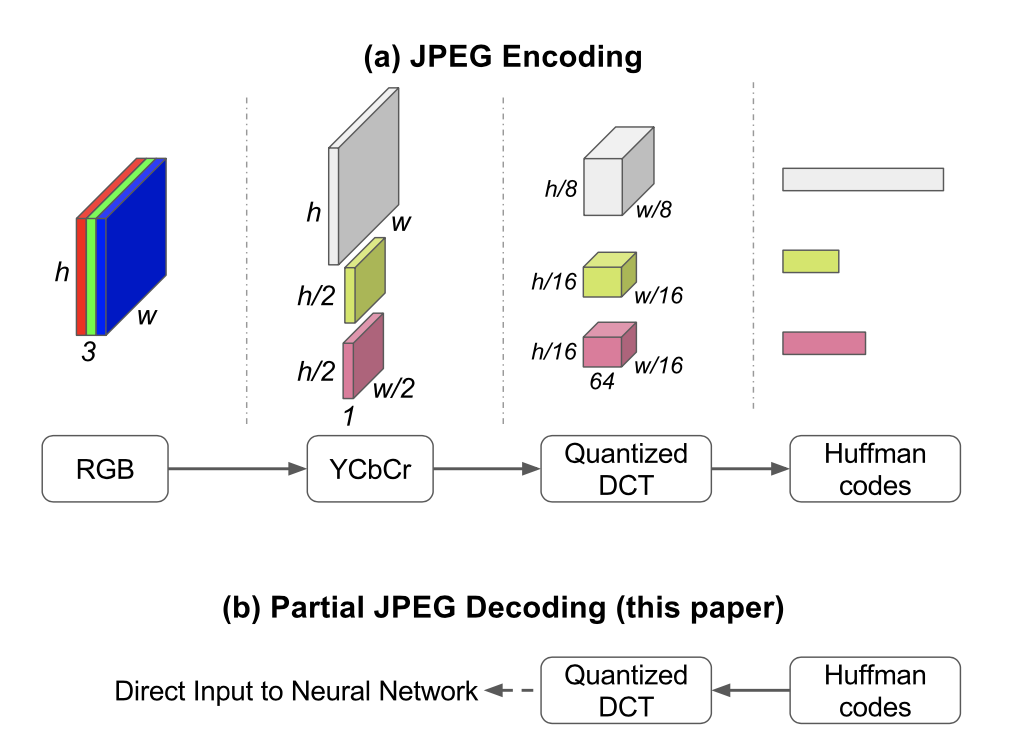)

So what we actually have now is something akin to, i.e., what the output of the first layer of a neural network would produce. Also keep in mind that with a typical CNN, the first few layers would have overlapping strides whereas here, each 8 x 8 block (in luminance space) is strided by 8. This arrange makes sense given the encoding for each block is done disjointly, and ideally should actually speed up network modeling time considerably.

When I first tested the speed of this, I discovered this method is actually pretty slow. I was getting ~215 it / s whereas some other jpeg to RGB methods were hitting 600 it / s on my development server. What gives? The answer to this actually comes from the above image and this excerpt from the research:

> In summary, we found that speed gains are simply due to a smaller volume of data on the input layer and subsequent layers, as one might expect. Accuracy gains are due primarily to the specific use of a DCT representation, which turns out to work curiously well for image classification. ***Surprisingly, simply replacing the first convolutional layer of a ResNet-50 with the stride 8 DCT transform results in much better performance.*** It works even better than a learned transform of exactly the same shape. In other words, in contrast to conventional wisdom, we find that using larger receptive fields and strides (of 8 each) works better than small, and hard coding the first layer works better than learning it.

Emphasis belonging to the papers' authors. So in actuality, what we're getting here is the entire image already transformed through the orthonormal DCT basis! Picture it like this, the method above is actually producing **the** first layer output of a neural network (in software), hence why it's a bit slower. It would have been nice if they allowed us to do that ourselves in GPU space since it's dead easy to generate the DCT Basis and load them into a frozen convolutional layer:

# Orthonormal DCT Basis

In [ ]:
def DCT_Basis(repeats=None):
    N = 8
    basis = []
    for u in range(8):
        for v in range(8):
            z = np.zeros((N,N))
            for i in range(N):
                for j in range(N):
                    z[i,j] = np.cos(np.pi*(2*i+1)*u / (2*N)) * np.cos(np.pi*(2*j+1)*v / (2*N))
            basis.append(z)

    if repeats is None:
        return basis
    
    return torch.Tensor([basis,basis,basis]).permute((1,0,2,3))

In [ ]:
basis = DCT_Basis()

_, ax = plt.subplots(8,8,figsize=(12,12))
ax = ax.flatten()
for i in range(64):
    ax[i].imshow(basis[i], vmin=-1, vmax=1)
plt.show()

In [ ]:
conv = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=8, stride=8)# , groups=3)
conv.weight.data.shape

In [ ]:
conv.weight.data = DCT_Basis(repeats=3)
conv.required_grad = False
conv.weight.data.shape

But I guess beggars can't be choosers. In the [actual paper](https://papers.nips.cc/paper/7649-faster-neural-networks-straight-from-jpeg), they spend some time talking about this. They mention that:

> In JPEG compression, the DCT transform is applied to non-overlapping blocks of size 8×8. Each block is projected onto a basis of 64 patterns representing various horizontal, vertical, and composite frequencies. The basis is orthogonal, so any block can be fully recovered from the knowledge of its coefficients.

> The DCT can be thought of as convolution with a specific filter size of 8×8, stride of 8×8, one input channel, 64 output channels, and specific, non-learned orthonormal filters. The 64 filters are illustrated in Fig. 2a.

![Fig. 2a]( 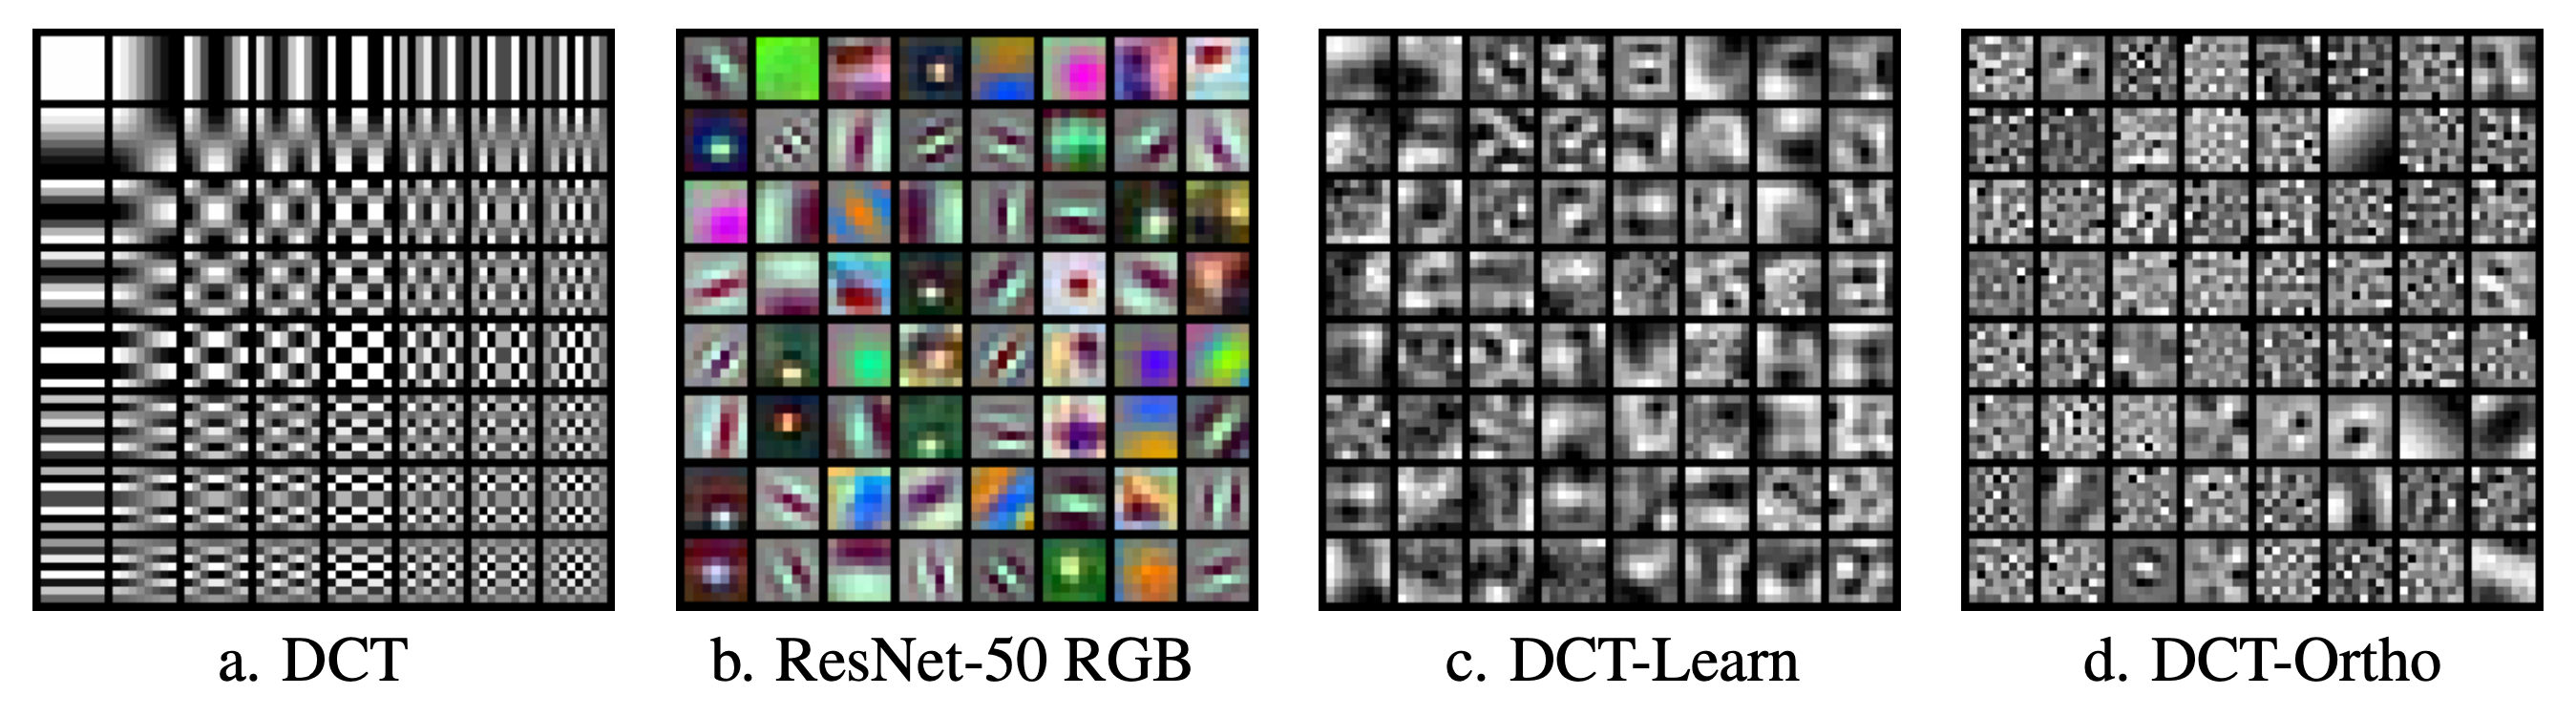)

> Let us consider a few details. Because the DCT processes each of the three input channels (one for luminance and two for chroma) separately, in terms of convolution it should be thought of as a three separate applications of convolution to three single-channel input images (equivalently: depthwise convolution), because information from separate input channels stays separate. Because the filter size and stride are both 8, spatial information does not cross to adjacent blocks.


Perfect, that all makes sense. So we're getting a deeper (in terms of channel depth) representation of the data.

I just wanted to point out that while the standard stem convolutional layer may learn an orthonormal basis, in general it will not. Instead, learned bases may be undercomplete, complete but not orthogonal, or overcomplete, depending on the number of filters and spatial size. The result of this, compounded, is dead neurons throughout a network! However it's possible to add constraints to a network which force its bases to be orthonormal as shown in `Fig.2d.` of the image above.

Two years ago when word embeddings were still the craze before transformers, I had once tried to learn an embedding with Genism enforcing embedding basis were non correlated for an NLP competition here on Kaggle. To be honest, I had no idea what I was doing at the time, but—the Uber folks here make it seem I at least had my head in the right direction.

Alright, let's look at some of the data!

In [ ]:
from PIL import Image

# The original image
image = Image.open('../input/alaska2-image-steganalysis/Cover/00001.jpg')
plt.imshow(image)

## Luminance Projections

In [ ]:
_, ax = plt.subplots(8,8,figsize=(32,32))

ax = ax.flatten()
for i in range(64):
    ax[i].imshow(dct_y[:,:,i])
    
plt.axis("off")
plt.axis("tight")
plt.axis("image") 
plt.show()

## Cb Projections

In [ ]:
_, ax = plt.subplots(8,8,figsize=(32,32))

ax = ax.flatten()
for i in range(64):
    ax[i].imshow(dct_cb[:,:,i])
    
plt.axis("off")
plt.axis("tight")
plt.axis("image") 
plt.show()

## Cr Projections

In [ ]:
_, ax = plt.subplots(8,8,figsize=(32,32))

ax = ax.flatten()
for i in range(64):
    ax[i].imshow(dct_cr[:,:,i])
    
plt.axis("off")
plt.axis("tight")
plt.axis("image") 
plt.show()

# Finall Thoughts!



If you decide to experiment further in the DCT realm, a few notes to keep in mind:
- ResNets don't work for this problem 😔.
- That stated, a few competitors have mentioned SEResNeXT models do indeed work.
- In this work, uber chopped off the entire ResNet blocks 1 and 2.
- I do not know what this would map to for EfficientNets.
- The JPEG2DCT paper recommends processing the Luminance (Y) channel (it enters the network in ResNet block 3), and then late fuzing the Cb and Cr channels (they enter the network at block 4).
- Intuitively, this makes sense since `Y` contains the most data that needs to be understood, like textures.
- Also worth noting that care needs to be taken if using JEPG2DCT such that when Cb and Cr are merged into the network, they are done at such a time that it spatially makes sense.
- Those feature maps are 1/2 the size but still encode the same final image resolution, which means their respective receptive fields are 2x that of the luminance channel.
- Team? It takes like 30 hours to test each idea to convergence, and iteration time is of the utmost essence
- One more [gold mine](https://www.egr.msu.edu/waves/people/Ali_files/DCT_TR802.pdf).